# 8.1. Deep Convolutional Neural Networks (AlexNet)


Although some neural network accelerators were available in the 1990s, they were not yet sufficiently powerful to make deep multichannel, multilayer CNNs with a large number of parameters. For instance, NVIDIA’s GeForce 256 from 1999 was able to process at most 480 million floating-point operations, such as additions and multiplications, per second (MFLOPS), without any meaningful programming framework for operations beyond games. Today’s accelerators are able to perform in excess of 1000 TFLOPs per device.

The dirty truth of image recognition, they would tell you, is that features, geometry (Hartley and Zisserman, 2000, Hartley and Kahl, 2009), and engineering, rather than novel learning algorithms, drove progress. Computer vision researchers justifiably believed that a slightly bigger or cleaner dataset or a slightly improved feature-extraction pipeline mattered far more to the final accuracy than any learning algorithm.

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 8.1.1. Representation Learning

They believed that features themselves ought to be learned. Moreover, they believed that to be reasonably complex, the features ought to be hierarchically composed with multiple jointly learned layers, each with learnable parameters. In the case of an image, the lowest layers might come to detect edges, colors, and textures, by analogy with how the visual system in animals processes its input.

The first modern CNN (Krizhevsky et al., 2012), named AlexNet after one of its inventors, Alex Krizhevsky, is largely an evolutionary improvement over LeNet. It achieved excellent performance in the 2012 ImageNet challenge.

## 8.1.2. AlexNet

https://d2l.ai/_images/alexnet.svg
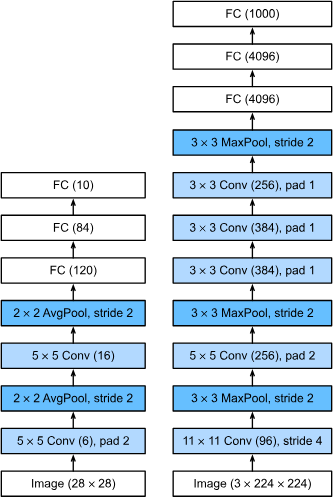

There are also significant differences between AlexNet and LeNet. 

First, AlexNet is much deeper than the comparatively small LeNet-5. 

AlexNet consists of eight layers: five convolutional layers, two fully connected hidden layers, and one fully connected output layer. 

Second, AlexNet used the ReLU instead of the sigmoid as its activation function. Let’s delve into the details below.

### 8.1.2.1. Architecture

Since the images in ImageNet are eight times taller and wider than the MNIST images, objects in ImageNet data tend to occupy more pixels with more visual detail.

In addition, after the first, second, and fifth convolutional layers, the network adds max-pooling layers with a window shape of 
 and a stride of 2. Moreover, AlexNet has ten times more convolution channels than LeNet.

After the final convolutional layer, there are two huge fully connected layers with 4096 outputs. These layers require nearly 1GB model parameters. Because of the limited memory in early GPUs, the original AlexNet used a dual data stream design, so that each of their two GPUs could be responsible for storing and computing only its half of the model. 
早起的GPU资源不足的情况下，一个模型需要分给两个GPU去计算，训练完成之后再将数据进行合并。

### 8.1.2.2. Activation Functions

激活函数换成了ReLU，主要有几个原因：
1. 计算更加简单，没有指数计算
2. 导数都是1，不存在梯度消失和爆炸

### 8.1.2.3. Capacity Control and Preprocessing

- nn.LazyConv2d：这是一个延迟初始化的 2D 卷积层，LazyConv2d 是 Conv2d 的变体，允许延迟设置输入通道数。第一个参数是输出通道数（例如，96, 256, 384），kernel_size 是卷积核的大小，stride 表示步幅，padding 用于在输入图像的边缘补零。LazyConv2d 在第一次接收到输入时，会根据输入自动推断出输入通道的数量。

- nn.ReLU：这是一个非线性激活函数，使用了修正线性单元（ReLU），输出为 max(0, x)，常用于引入非线性特性。

- nn.MaxPool2d：2D 最大池化层，主要用于下采样，减少特征图的尺寸。kernel_size 表示池化窗口的大小，stride 控制池化操作的步幅。

- nn.Flatten：将多维输入（通常是卷积后的特征图）展平成一维，用于连接全连接层。

- nn.LazyLinear：延迟初始化的全连接层，用于将展平后的特征图映射到指定维度的输出。LazyLinear 会在第一次运行时自动推断输入的维度，类似于 LazyConv2d。

- nn.Dropout(p=0.5)：Dropout 是一种正则化技术，防止过拟合。p=0.5 表示有 50% 的神经元在每次训练时会随机失活，减轻模型的过拟合风险。

- num_classes：这是最后一层全连接层的输出单元数，表示分类任务中的类别数量。

In [2]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            # 11x11 Conv(96), stride 4, padding 1
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), 
            
            # 3x3 MaxPool, stride 2
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # 5x5 Conv(256), padding 2
            nn.LazyConv2d(256, kernel_size=5, padding=2), 
            nn.ReLU(),
            
            # 3x3 MaxPool, stride 2
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # 3x3 Conv(384), padding 1
            nn.LazyConv2d(384, kernel_size=3, padding=1), 
            nn.ReLU(),
            
            # 3x3 Conv(384), padding 1
            nn.LazyConv2d(384, kernel_size=3, padding=1), 
            nn.ReLU(),
            
            # 3x3 Conv(256), padding 1
            nn.LazyConv2d(256, kernel_size=3, padding=1), 
            nn.ReLU(),
            
            # 3x3 MaxPool, stride 2
            nn.MaxPool2d(kernel_size=3, stride=2), 
            nn.Flatten(),
            
            # Full Connect Layer
            nn.LazyLinear(4096), 
            nn.ReLU(), 
            nn.Dropout(p=0.5),
            
            # Full Connect Layer
            nn.LazyLinear(4096), 
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            # Full Connect Layer
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

在卷积神经网络（CNN）中，通常在每个卷积层后面都跟着一个激活函数（如 ReLU），但这并不是绝对的规则。具体原因和效果如下：

### 为什么通常在卷积层后面跟激活函数？
1. **引入非线性**：卷积层本质上是一个线性运算，只是在输入上执行矩阵乘法和加法。没有激活函数的情况下，多个卷积层的组合仍然是线性的。激活函数（如 ReLU）引入非线性，使得网络能够表达更加复杂的非线性特征。
   
2. **增强学习能力**：网络的学习能力取决于它能否从数据中提取有用的特征。激活函数能够打破线性特性，使网络能够学习复杂的模式和特征，从而提高模型的表现力。

3. **避免梯度消失问题**：激活函数如 ReLU（Rectified Linear Unit）有助于解决深层网络中的梯度消失问题。ReLU 函数的正输出部分是线性的，这可以有效地传递梯度并加速训练。

### 常用的激活函数：
- **ReLU**（Rectified Linear Unit）：输出为 `max(0, x)`，即将负值设为 0，正值保持不变。这是最常用的激活函数，特别适合深度神经网络。
- **Sigmoid**：将输出限制在 `[0, 1]` 之间，常用于二分类问题，但在深度网络中容易引发梯度消失问题。
- **Tanh**：输出范围在 `[-1, 1]`，与 Sigmoid 类似，也会引发梯度消失问题，通常较少用于深层网络。
- **Leaky ReLU**：是 ReLU 的变种，允许负值部分以较小的斜率通过，避免 ReLU 的死神经元问题。

### 不使用激活函数的情况：
- **最后一层卷积层**：在有些特殊的模型设计中，最后一个卷积层不一定会跟激活函数，尤其是如果输出是用于回归任务或其他特殊需求时。
- **残差网络（ResNet）**：有时为了保持残差的特性，一些残差连接后的卷积层可能不会立即应用激活函数。

### 总结：
- **通常**：卷积层后面跟激活函数是常见的实践，因为这有助于提升模型的非线性表现和学习能力。
- **例外情况**：特殊的架构或任务可能不需要在某些层后面添加激活函数，具体取决于设计需求。

在大多数卷积神经网络中，每个卷积层后跟着激活函数（特别是 ReLU）几乎是标准做法，以确保网络能够从输入中学习复杂的特征。

In [3]:
# We construct a single-channel data example 
# with both height and width of 224 to observe the output shape of each layer. 
AlexNet().layer_summary((1,1,224,224))

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [4]:
alex_net_model = AlexNet(lr=0.5)

In [5]:
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))

In [6]:
!nvidia-smi

Thu Oct 10 22:40:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   37C    P8             10W /  165W |    1576MiB /  16380MiB |     35%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


Running on the GPU


In [8]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)

In [9]:
trainer.fit(alex_net_model, data)